In [43]:
import pyfits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import sklearn.neighbors.kde as kde

In [21]:
tru_hdulist = pyfits.open('Buzzard_v1.1_truth.147.fit')

In [22]:
tru_hdulist.info()

Filename: Buzzard_v1.1_truth.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU    113   5022692R x 48C   [K, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, E, E, E, J, E, E, J, E, I, E, E, 2E, E, E, E, E, 5E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, E, E]   


In [23]:
tru_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  330 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   48 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [82]:
tru_data = tru_hdulist[1].data

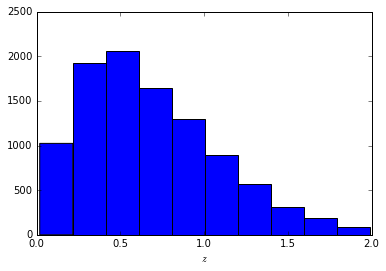

In [112]:
# warning, KDE is slow!
# X = np.random.choice(tru_data['Z'],10000)
# kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
# X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
# res = kde_test.score_samples(X_plot)
# plt.plot(X_plot[:, 0], res)

plt.hist(np.random.choice(tru_data['Z'],10000))
plt.xlabel(r'$z$')

In [104]:
indices = np.random.choice(range(0,len(tru_data)),10000)
print(tru_data['COEFFS'][indices][:,0])

[  6.47073875e-06   1.51938957e-06   1.88441834e-06 ...,   1.95364714e-06
   3.13945293e-06   4.11977759e-08]


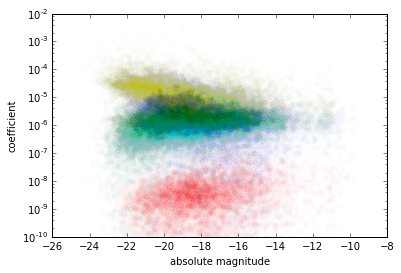

In [109]:
colors = 'brgycm'
for b in xrange(5):
    plt.scatter(tru_data['AMAG'][indices][:,b],tru_data['COEFFS'][indices][:,b],color=colors[b],alpha=0.01)
plt.semilogy()
plt.ylim(1e-10,1e-2)
plt.xlabel('absolute magnitude')
plt.ylabel('coefficient')
#print(np.shape(tru_data['COEFFS'][indices][:,0]),np.shape(tru_data['AMAG'][indices][:,0]))

In [28]:
obs_hdulist = pyfits.open('Buzzard_v1.1.147.fit')

In [29]:
obs_hdulist.info()

Filename: Buzzard_v1.1.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU     87   5022692R x 35C   [K, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [30]:
obs_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  144 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [31]:
obs_data = hdulist[1].data

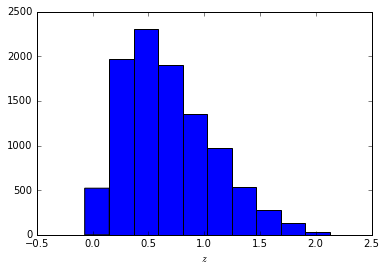

In [116]:
# warning, KDE is slow!
# X = np.random.choice(obs_data['PHOTOZ_GAUSSIAN'],10000)
# kde_test = kde.KernelDensity(kernel='gaussian', bandwidth=1.).fit(X.reshape(-1,1))
# X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
# res = kde_test.score_samples(X_plot)
# indices = np.random.choice(range(0,len(obs_data)),10000)

plt.hist(obs_data['PHOTOZ_GAUSSIAN'][indices])
plt.xlabel(r'$z$')

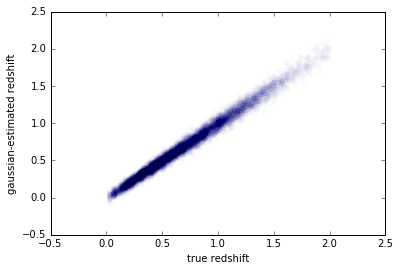

In [114]:
plt.scatter(tru_data['Z'][indices],obs_data['PHOTOZ_GAUSSIAN'][indices],alpha=0.01)
plt.xlabel('true redshift')
plt.ylabel('gaussian-estimated redshift')